In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# For submission
test_dir = "test_petimages/"
submission_file = "submission.csv"

# For training and testing
train_dir = "train_petimages/"

cat_dir= os.path.join(train_dir, "cat")
dog_dir= os.path.join(train_dir, "dog")

First, I separated dogs images from cat images in data set. This container runs once only.

In [18]:
# Create directories
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move files to appropriate directories
for file in os.listdir(train_dir):
    if file.startswith("cat"):
        shutil.move(os.path.join(train_dir, file), cat_dir)
    elif file.startswith("dog"):
        shutil.move(os.path.join(train_dir, file), dog_dir)



I created functions to clean data set from anomalies, and I used Pillow for opening, manipulating, and saving image files. I resized all images to 128x128 pixels and converted them to RGB. I also normalized the pixel values to be between 0 and 1.

In [2]:
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except:
        return False
    
def clean_image_directory(base_dir):
    for root, directories, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                print(f"Removing {file_path}")
                os.remove(file_path)
    

def load_images(file_paths, labels=None, target_size=(128, 128)):
    images = []
    labels_list = []
    for i, file_path in enumerate(file_paths):
        try:
            img = Image.open(file_path).convert("RGB").resize(target_size)
            images.append(np.array(img) / 255.0)
            if labels is not None:
                labels_list.append(labels[i])
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels_list) if labels is not None else None

clean_image_directory(train_dir)

Then, I split the train_petimages cats and dogs data sets into 2 parts, one for training (75%) and one for testing (25%), and I configured data augmentation for the training data set.

In [20]:
# Define paths
train_dir = "train_petimages/"
test_dir = "test_petimages/"

# Data augmentation for training data
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # wide range of image brightness
    validation_split=0.25
)

# Generators for training and validation data
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Allow 5 epochs with no improvement
    restore_best_weights=True  # Revert to the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

Found 14999 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [21]:
# the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),  # Adding batch normalization
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
469/469 [==============================] - 420s 893ms/step - loss: 1.1755 - accuracy: 0.6291 - val_loss: 1.4354 - val_accuracy: 0.5456 - lr: 1.0000e-04
Epoch 2/20
469/469 [==============================] - 446s 950ms/step - loss: 1.0402 - accuracy: 0.6888 - val_loss: 0.9952 - val_accuracy: 0.7013 - lr: 1.0000e-04
Epoch 3/20
469/469 [==============================] - 437s 932ms/step - loss: 0.9692 - accuracy: 0.7121 - val_loss: 0.9201 - val_accuracy: 0.7445 - lr: 1.0000e-04
Epoch 4/20
469/469 [==============================] - 475s 1s/step - loss: 0.9005 - accuracy: 0.7389 - val_loss: 0.8958 - val_accuracy: 0.7265 - lr: 1.0000e-04
Epoch 5/20
469/469 [==============================] - 1285s 3s/step - loss: 0.8437 - accuracy: 0.7571 - val_loss: 0.8048 - val_accuracy: 0.7685 - lr: 1.0000e-04
Epoch 6/20
469/469 [==============================] - 476s 1s/step - loss: 0.7820 - accuracy: 0.7759 - val_loss: 0.8557 - val_accuracy: 0.7269 - lr: 1.0000e-04
Epoch 7/20
469/469 [==========

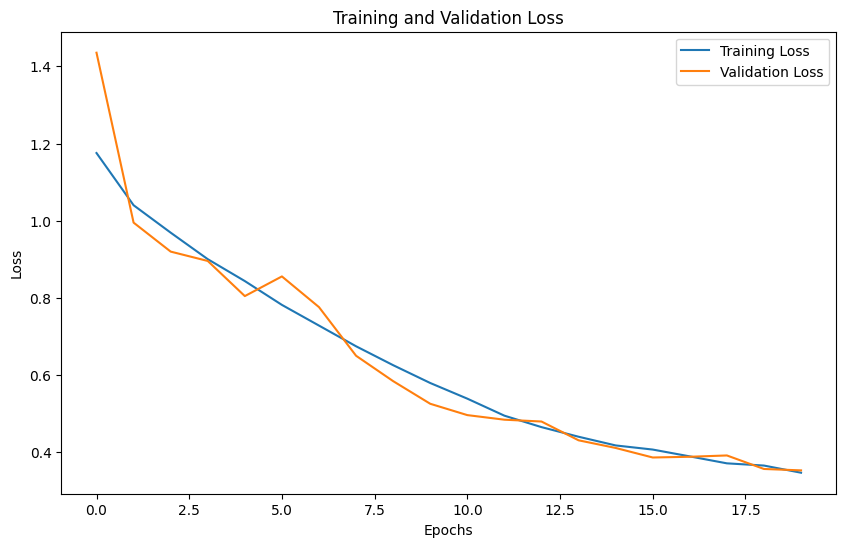

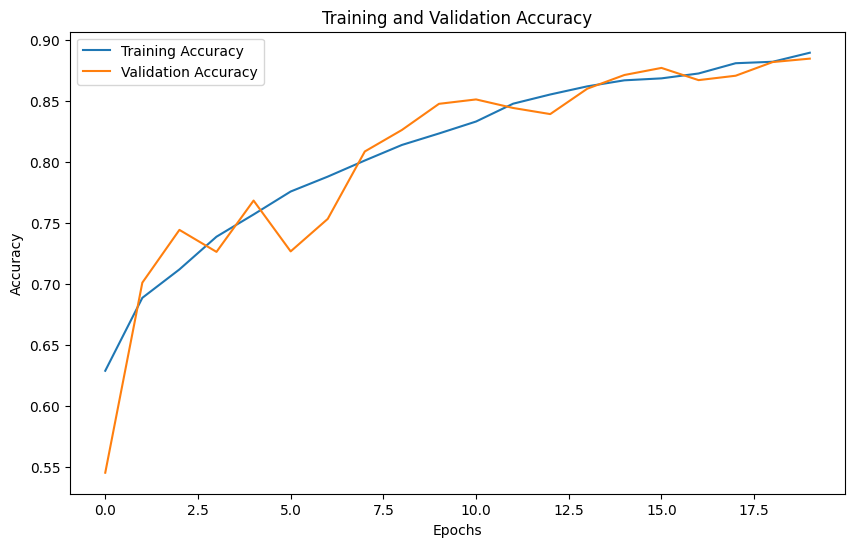

In [23]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Predict on test data
def predict_test_images(test_dir, model, output_csv):
    test_files = [f for f in os.listdir(test_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    results = []

    for file in test_files:
        try:
            img_path = os.path.join(test_dir, file)
            img = Image.open(img_path).convert("RGB").resize((128, 128))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array, verbose=0)
            label = 'dog' if prediction[0][0] > 0.5 else 'cat'

            file_name_without_ext = os.path.splitext(file)[0]
            results.append((file_name_without_ext, label))

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    df = pd.DataFrame(results, columns=['ImageId', 'Label'])
    df.to_csv(output_csv, index=False)

# Generate predictions and save to CSV
output_csv = "submission.csv"
predict_test_images(test_dir, model, output_csv)

d:\Work\04_Program-Files\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


A simple function to plot the first 25 images from the training set was created to visualize the data.

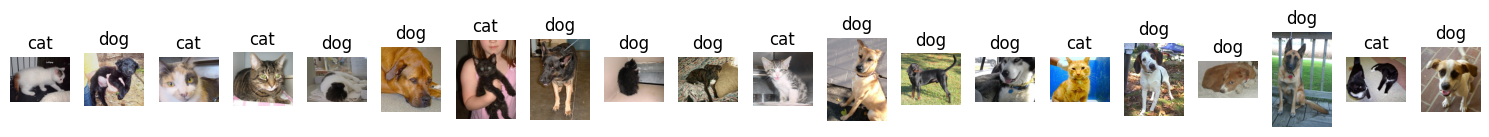

In [33]:
# Step 1: Load the CSV file
csv_file = 'submission.csv'  # Replace with your CSV file path
image_dir = 'test_petimages'  # Replace with the directory containing the images

data = pd.read_csv(csv_file,dtype={'ImageId': str})

# Step 2: Display a few images with labels
def display_images(data, image_dir, num_images=5, extension='.jpg'):
    """
    Display a few images with their labels from a CSV file.
    
    Parameters:
    - data (DataFrame): DataFrame containing 'ImageId' and 'Label' columns.
    - image_dir (str): Directory containing the images.
    - num_images (int): Number of images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(data):
            break
        
        # Get image path and label
        image_name = str(data.iloc[i]['ImageId'])
        label = data.iloc[i]['Label']
        image_path = os.path.join(image_dir, image_name+extension)

        
        # Load and display the image
        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            ax.set_title(label)  # Set label as the title
        except FileNotFoundError:
            ax.set_title(f"Image not found: {image_name}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display images
display_images(data, image_dir, num_images=20,extension='.jpg')
